In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import statsmodels.tsa.stattools as ts
import math

/Users/wuqian/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:7: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,
/Users/wuqian/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:7: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,


# 处理数据

In [4]:
# 2008-2015的数据
df_old = pd.read_csv('data/londonfixes.csv', error_bad_lines=False)
df_old.head()

/var/folders/5h/qjd_r64j0z7_4blzpt8yc0qr0000gn/T/ipykernel_74542/15712964.py:1: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  df_old = pd.read_csv('data/londonfixes.csv', error_bad_lines=False)
/var/folders/5h/qjd_r64j0z7_4blzpt8yc0qr0000gn/T/ipykernel_74542/15712964.py:1: DtypeWarning: Columns (3,6,8,10,12) have mixed types. Specify dtype option on import or set low_memory=False.
  df_old = pd.read_csv('data/londonfixes.csv', error_bad_lines=False)


,Market,London Fix,London Fix.1,London Fix.2,London Fix.3,London Fix.4,London Fix.5,London Fix.6,Lease Rates,Unnamed: 9,...,Unnamed: 78,Unnamed: 79,Unnamed: 80,Unnamed: 81,Unnamed: 82,Unnamed: 83,Unnamed: 84,Unnamed: 85,Unnamed: 86,Unnamed: 87
0,Metal/Currency,Gold,Gold,Silver,Platinum,Platinum,Palladium,Palladium,6 Month,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Priced In,USD,USD,USD,USD,USD,USD,USD,Gold,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Price Type,AM Fix,PM Fix,Fix,AM Fix,PM Fix,AM Fix,PM Fix,% pa,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Summary,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1/01/68,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
# 删除无用列
df_old = df_old.drop(df_old.columns[8:], axis=1)
df_old.head()

,Market,London Fix,London Fix.1,London Fix.2,London Fix.3,London Fix.4,London Fix.5,London Fix.6
0,Metal/Currency,Gold,Gold,Silver,Platinum,Platinum,Palladium,Palladium
1,Priced In,USD,USD,USD,USD,USD,USD,USD
2,Price Type,AM Fix,PM Fix,Fix,AM Fix,PM Fix,AM Fix,PM Fix
3,Summary,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1/01/68,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [17]:
# 2008年
df_old.loc[14628]

Market            15/01/08
London Fix          904.75
London Fix.1        913.00
London Fix.2         16.24
London Fix.3      1,580.00
London Fix.4     1,575.00 
London Fix.5       379.00 
London Fix.6       378.50 
Name: 14628, dtype: object

In [18]:
# 2015年
df_old.loc[17530]

Market          28/12/15
London Fix           NaN
London Fix.1         NaN
London Fix.2         NaN
London Fix.3         NaN
London Fix.4         NaN
London Fix.5         NaN
London Fix.6         NaN
Name: 17530, dtype: object

In [19]:
# 2008年-2015年
df_old = df_old.loc[14628:17530].copy(deep=True)

In [21]:
# 处理current dataset: 2016 - 2018
df_cur = pd.read_csv('data/londonfixes-current.csv', error_bad_lines=False)
df_cur = df_cur.drop(df_cur.columns[8:], axis=1)

/var/folders/5h/qjd_r64j0z7_4blzpt8yc0qr0000gn/T/ipykernel_74542/1103756590.py:2: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  df_cur = pd.read_csv('data/londonfixes-current.csv', error_bad_lines=False)
Skipping line 6: expected 9 fields, saw 20
Skipping line 7: expected 9 fields, saw 20
Skipping line 8: expected 9 fields, saw 20
Skipping line 14: expected 9 fields, saw 20
Skipping line 15: expected 9 fields, saw 20
Skipping line 21: expected 9 fields, saw 20
Skipping line 22: expected 9 fields, saw 20
Skipping line 28: expected 9 fields, saw 20
Skipping line 29: expected 9 fields, saw 20
Skipping line 35: expected 9 fields, saw 20
Skipping line 36: expected 9 fields, saw 20
Skipping line 42: expected 9 fields, saw 20
Skipping line 43: expected 9 fields, saw 20
Skipping line 49: expected 9 fields, saw 20
Skipping line 50: expected 9 fields, saw 20
Skipping line 56: expected 9 fields, saw 20


In [22]:
# 两表合并
df_cur = df_cur.append(df_old, ignore_index=True)
# 把列名换成Metal名
df_cur.columns=['Date','gold-am','gold-pm','silver-am','plat-am','plat-pm','pal-am','pal-pm']
# 从第四行开始，因为前四行是metadata
df_cur = df_cur[4:]
df_cur

/var/folders/5h/qjd_r64j0z7_4blzpt8yc0qr0000gn/T/ipykernel_74542/98378098.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_cur = df_cur.append(df_old, ignore_index=True)


,Date,gold-am,gold-pm,silver-am,plat-am,plat-pm,pal-am,pal-pm
4,04/01/16,1072.7,1082.25,14,878,893,547,550
5,05/01/16,1078,1077,14.01,890,893,545,544
6,06/01/16,1083.85,1091.4,14.005,885,873,532,519
7,07/01/16,1096,1106.35,14.03,869,865,496,486
8,08/01/16,1097.45,1101.85,14.04,876,874,498,505
...,...,...,...,...,...,...,...,...
3610,24/12/15,"1,071.90",NaN,14.2,874.00,NaN,554.0,NaN
3611,25/12/15,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3612,26/12/15,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3613,27/12/15,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [23]:
# dataframe for am
df_new = pd.DataFrame()
df_new['date'] = pd.to_datetime(df_cur['Date'], dayfirst=True)
df_new['gold'] = pd.to_numeric(df_cur['gold-am'].str.replace(',',''))
df_new['plat'] = pd.to_numeric(df_cur['plat-am'].str.replace(',',''))
df_new['silver'] = pd.to_numeric(df_cur['silver-am'])
df_new['pal'] = pd.to_numeric(df_cur['pal-am'])
df_new

,date,gold,plat,silver,pal
4,2016-01-04,1072.70,878.0,14.000,547.0
5,2016-01-05,1078.00,890.0,14.010,545.0
6,2016-01-06,1083.85,885.0,14.005,532.0
7,2016-01-07,1096.00,869.0,14.030,496.0
8,2016-01-08,1097.45,876.0,14.040,498.0
...,...,...,...,...,...
3610,2015-12-24,1071.90,874.0,14.200,554.0
3611,2015-12-25,NaN,NaN,NaN,NaN
3612,2015-12-26,NaN,NaN,NaN,NaN
3613,2015-12-27,NaN,NaN,NaN,NaN


In [24]:
# dataframe for pm
df_pm = df_new.copy(deep=True)
df_pm.date = df_pm.date + pd.Timedelta('8 hours')
df_pm['gold'] = pd.to_numeric(df_cur['gold-pm'].str.replace(',',''))
df_pm['plat'] = pd.to_numeric(df_cur['plat-pm'].str.replace(',',''))
df_pm['silver'] = pd.to_numeric(df_cur['silver-am'])
df_pm['pal'] = pd.to_numeric(df_cur['pal-pm'].str.replace(',','').str.replace(' ', ''))
df_pm

,date,gold,plat,silver,pal
4,2016-01-04 08:00:00,1082.25,893.0,14.000,550.0
5,2016-01-05 08:00:00,1077.00,893.0,14.010,544.0
6,2016-01-06 08:00:00,1091.40,873.0,14.005,519.0
7,2016-01-07 08:00:00,1106.35,865.0,14.030,486.0
8,2016-01-08 08:00:00,1101.85,874.0,14.040,505.0
...,...,...,...,...,...
3610,2015-12-24 08:00:00,NaN,NaN,14.200,NaN
3611,2015-12-25 08:00:00,NaN,NaN,NaN,NaN
3612,2015-12-26 08:00:00,NaN,NaN,NaN,NaN
3613,2015-12-27 08:00:00,NaN,NaN,NaN,NaN


In [25]:
# df_am和df_pm合并
df_new = df_new.append(df_pm, ignore_index=True)
df_new = df_new.sort_values('date').reset_index()
df_new

/var/folders/5h/qjd_r64j0z7_4blzpt8yc0qr0000gn/T/ipykernel_74542/3625138344.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_new = df_new.append(df_pm, ignore_index=True)


,index,date,gold,plat,silver,pal
0,708,2008-01-15 00:00:00,904.75,1580.0,16.240,379.0
1,4319,2008-01-15 08:00:00,913.00,1575.0,16.240,378.5
2,709,2008-01-16 00:00:00,881.00,1564.0,15.850,375.0
3,4320,2008-01-16 08:00:00,889.75,1561.0,15.850,375.0
4,710,2008-01-17 00:00:00,881.50,1561.0,15.880,373.0
...,...,...,...,...,...,...
7217,4316,2018-09-26 08:00:00,1194.25,824.0,14.475,1065.0
7218,706,2018-09-27 00:00:00,1196.00,829.0,14.420,1075.0
7219,4317,2018-09-27 08:00:00,1185.40,812.0,14.420,1067.0
7220,707,2018-09-28 00:00:00,1183.50,811.0,14.305,1086.0


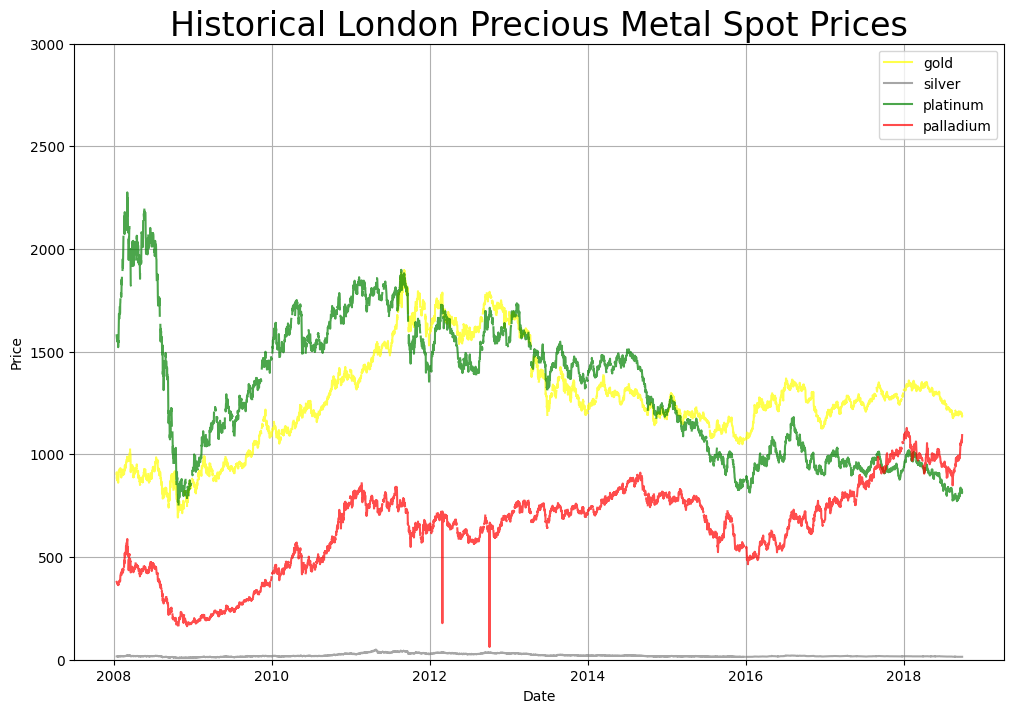

In [26]:
plt.figure(figsize=(12, 8))
plt.plot(df_new['date'], df_new['gold'], color='yellow', label='gold', alpha=0.7)
plt.plot(df_new['date'], df_new['silver'], color='gray', label='silver', alpha=0.7)
plt.plot(df_new['date'], df_new['plat'], color='green', label='platinum', alpha=0.7)
plt.plot(df_new['date'], df_new['pal'], color='red', label='palladium', alpha=0.7)

plt.xlabel('Date')
plt.ylabel('Price')
plt.ylim([0, 3000])

plt.title('Historical London Precious Metal Spot Prices', fontsize=24)
plt.grid()
plt.legend()

In [31]:
# due to some documentation error or some fluke, so we will exclude these values from our dataset.
print(df_new.iloc[3000:6000].query('pal < 250'))
df_new['pal'] = np.where(df_new['pal'] < 250, np.nan, df_new['pal'])

print(df_new.iloc[3000:6000].query('pal < 250'))

Empty DataFrame
Columns: [index, date, gold, plat, silver, pal]
Index: []
Empty DataFrame
Columns: [index, date, gold, plat, silver, pal]
Index: []


In [32]:
df_new

,index,date,gold,plat,silver,pal
0,708,2008-01-15 00:00:00,904.75,1580.0,16.240,379.0
1,4319,2008-01-15 08:00:00,913.00,1575.0,16.240,378.5
2,709,2008-01-16 00:00:00,881.00,1564.0,15.850,375.0
3,4320,2008-01-16 08:00:00,889.75,1561.0,15.850,375.0
4,710,2008-01-17 00:00:00,881.50,1561.0,15.880,373.0
...,...,...,...,...,...,...
7217,4316,2018-09-26 08:00:00,1194.25,824.0,14.475,1065.0
7218,706,2018-09-27 00:00:00,1196.00,829.0,14.420,1075.0
7219,4317,2018-09-27 08:00:00,1185.40,812.0,14.420,1067.0
7220,707,2018-09-28 00:00:00,1183.50,811.0,14.305,1086.0


# Cointegration/Correlation

In [33]:
# Testing for Cointegration/Correlation
# 每两个metal算 Cointegration/Correlation
for metal1 in df_new.columns[2:]:
    for metal2 in df_new.columns[2:]:
        if metal1 == metal2:
            continue
        # 使用 query() 方法从 df_new 数据框中筛选出包含当前两个金属数据的子集，并将其存储在 df_comp 数据框中。
        df_comp = df_new.query('{} == {} and {} == {}'.format(metal1, metal1, metal2, metal2))
        print('Cointergration Test for %s and %s' % (metal1, metal2))
        coint, pval, crit = ts.coint(df_comp[metal1], df_comp[metal2])
        print('Cointegration T-statistic: %0.2f' % coint)
        print('P-value: %0.5f' % pval)
        if pval < 0.05:
            print('SIGNIFICANT')
        else:
            print('INSIGNIFICANT')
        print('============================================================')

Cointergration Test for gold and plat
Cointegration T-statistic: -2.05
P-value: 0.50438
INSIGNIFICANT
Cointergration Test for gold and silver
Cointegration T-statistic: -2.41
P-value: 0.32112
INSIGNIFICANT
Cointergration Test for gold and pal
Cointegration T-statistic: -1.56
P-value: 0.73893
INSIGNIFICANT
Cointergration Test for plat and gold
Cointegration T-statistic: -2.14
P-value: 0.45581
INSIGNIFICANT
Cointergration Test for plat and silver
Cointegration T-statistic: -2.13
P-value: 0.45888
INSIGNIFICANT
Cointergration Test for plat and pal
Cointegration T-statistic: -2.33
P-value: 0.35893
INSIGNIFICANT
Cointergration Test for silver and gold
Cointegration T-statistic: -2.24
P-value: 0.40318
INSIGNIFICANT
Cointergration Test for silver and plat
Cointegration T-statistic: -2.25
P-value: 0.40031
INSIGNIFICANT
Cointergration Test for silver and pal
Cointegration T-statistic: -1.36
P-value: 0.81252
INSIGNIFICANT
Cointergration Test for pal and gold
Cointegration T-statistic: -0.76
P-val

# Eigenportfolio PCA Approach
## use PCA (Principal Component Analysis) in order to decompose this historical market.


In [34]:
# Eigenportfolio PCA Approach
# use PCA (Principal Component Analysis) in order to decompose this historical market.
df_svd = df_new[['date', 'gold', 'silver', 'plat', 'pal']]
# 把一行里所有元素都是nan的给删了
df_svd = df_svd[~df_svd.iloc[:, 1:].isnull().all(1)] # all(1)的作用是判断`df_svd.iloc[:, 1:]`中每一行的所有元素是否都为缺失值（NaN）

In [35]:
# 按每列计算一个df的return
def create_daily_returns_matrix(df):
    df_returns = pd.DataFrame()
    df_returns['date'] = df['date']
    for col in df.columns[1:]:
        df_returns[col] = df[col].pct_change()
    return df_returns

In [36]:
df_pct = create_daily_returns_matrix(df_svd).fillna(0)
df_pct.head()

,date,gold,silver,plat,pal
0,2008-01-15 00:00:00,0.000000,0.000000,0.000000,0.000000
1,2008-01-15 08:00:00,0.009119,0.000000,-0.003165,-0.001319
2,2008-01-16 00:00:00,-0.035049,-0.024015,-0.006984,-0.009247
3,2008-01-16 08:00:00,0.009932,0.000000,-0.001918,0.000000
4,2008-01-17 00:00:00,-0.009272,0.001893,0.000000,-0.005333


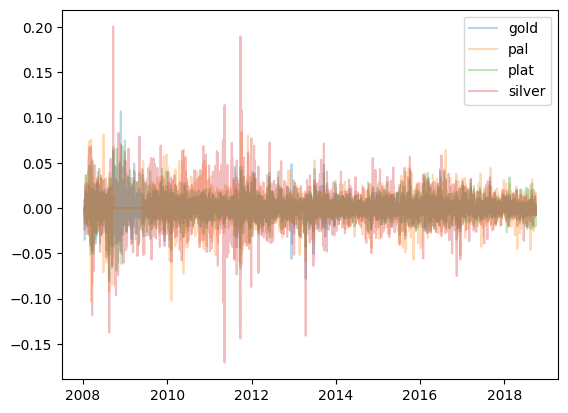

In [37]:
# return的plot
plt.plot(df_pct['date'], df_pct['gold'], alpha=0.3, label='gold')
plt.plot(df_pct['date'], df_pct['pal'], alpha=0.3, label='pal')
plt.plot(df_pct['date'], df_pct['plat'], alpha=0.3, label='plat')
plt.plot(df_pct['date'], df_pct['silver'], alpha=0.3, label='silver')
plt.legend()

In [38]:
# 计算return的协方差
vectorized = df_pct.iloc[:,1:] # 去除date那列
covariance = np.matmul(vectorized.T, vectorized)

# 计算eigen value and eigen vector
eig_vals, eig_vecs = np.linalg.eig(covariance)
eig_vecs = eig_vecs.T
sort_indices = eig_vals.argsort()[::-1]
eig_vals = eig_vals[sort_indices]
eig_vecs = eig_vecs[sort_indices]

/var/folders/5h/qjd_r64j0z7_4blzpt8yc0qr0000gn/T/ipykernel_74542/3668164409.py:3: FutureWarning: Calling a ufunc on non-aligned DataFrames (or DataFrame/Series combination). Currently, the indices are ignored and the result takes the index/columns of the first DataFrame. In the future , the DataFrames/Series will be aligned before applying the ufunc.
Convert one of the arguments to a NumPy array (eg 'ufunc(df1, np.asarray(df2)') to keep the current behaviour, or align manually (eg 'df1, df2 = df1.align(df2)') before passing to the ufunc to obtain the future behaviour and silence this warning.
  covariance = np.matmul(vectorized.T, vectorized)


In [39]:
eig_vals

array([2.00364264, 0.64552019, 0.30105629, 0.19063866])

In [40]:
eig_vecs

array([[ 0.29130074,  0.71401972,  0.4220406 ,  0.47665653],
       [-0.05127048, -0.62001089,  0.24423093,  0.74384749],
       [-0.53797112,  0.31222698, -0.64999714,  0.43658344],
       [ 0.78936829, -0.09097608, -0.58286936,  0.169954  ]])

# Backtest

In [46]:
# 回测函数
def backtest(starting_alloc, starting_cash, df_pct, years=10, portfolio_name='10 year Eigenportfolio', ax=None):
    # risk-free rate
    ffr = 2

    # 起始仓位：只有现金
    alloc = [starting_cash]

    # cumulative return:
    rel_returns = (df_pct.iloc[:,1:]).copy(deep=True)
    for idx, item in enumerate(starting_alloc):
        # sign = 1 if item>0 else -1
        # rel_returns.iloc[:, idx] = 1 + sign * rel_returns.iloc[:, idx]
        rel_returns.iloc[:, idx] = 1 + rel_returns.iloc[:, idx]

    alloc = rel_returns.cumprod().multiply(np.absolute(starting_alloc), axis=1).sum(axis=1)

    # Plot returns(cum return)
    if not ax:
        ax = plt.figure(figsize=(12, 8)).gca()
    ax.plot(df_pct['date'], alloc, label=portfolio_name, alpha=0.5)
    ax.grid()
    ax.set_xlabel('Date')
    ax.set_ylabel('Portfolio Value')
    ax.set_title(portfolio_name)
    plt.legend()

    # Sharpe and Sortino Ratio 风险调整后收益率
    port_returns = alloc.pct_change() * 100
    std_returns = np.std(port_returns) * math.sqrt(252)
    sortino_returns = np.std(port_returns.where(port_returns < 0)) * math.sqrt(252)
    tot_returns = (alloc.iloc[-1] - starting_cash) / alloc[0]
    sign_returns = 1 if tot_returns >0 else -1

    annual_return = calc_annualized_return(np.absolute(tot_returns), years)* 100
    # sharpe = sign * (annual_return - ffr)/std_returns
    # sortino = sign * (annual_return - ffr) / sortino_returns
    sharpe = (annual_return - ffr)/std_returns
    sortino = (annual_return - ffr) / sortino_returns
    print('Portfolio: %s' % portfolio_name)
    print('Sharpe Ratio: %0.3f' % sharpe)
    print('Sortino Ratio: %0.3f' % sortino)

    return alloc, rel_returns, sharpe, sortino

def calc_annualized_return(cum_return, years):
    tot_return = 1+cum_return
    return math.e ** (math.log(tot_return)/years)-1

## Principal Eigenportfolio vs. Market

Portfolio: 10 Years Principal Eigenportfolio
Sharpe Ratio: 0.071
Sortino Ratio: 0.089
Portfolio: 10 Years Equal Weight Portfolio
Sharpe Ratio: 0.093
Sortino Ratio: 0.120


Text(0.5, 1.0, 'Principal Eigenportfolio vs. Market')

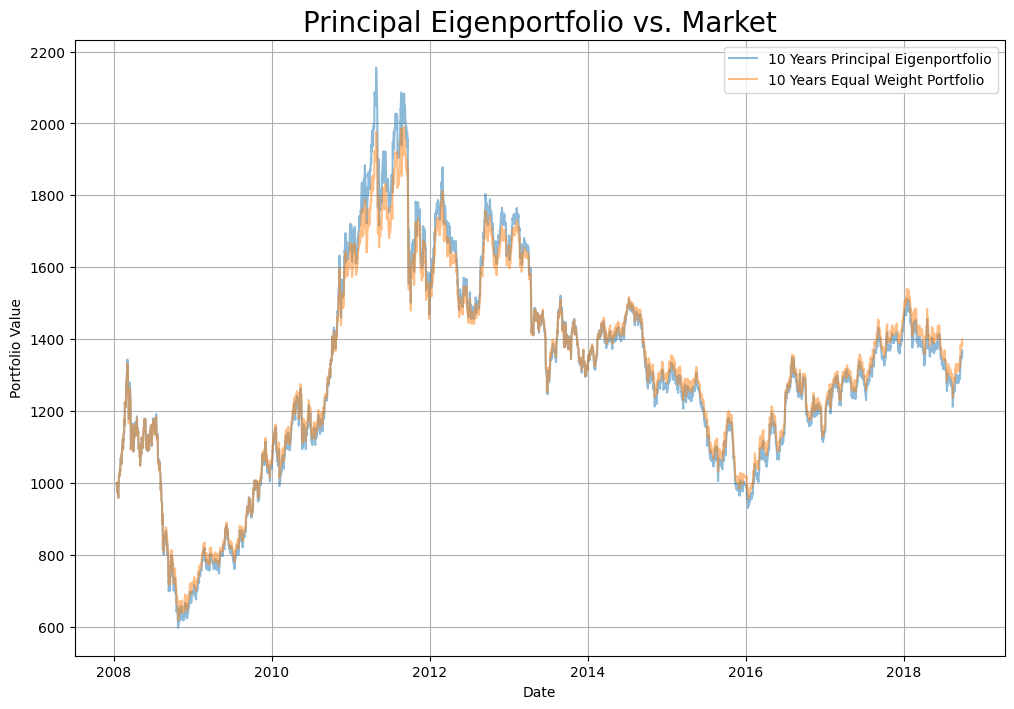

In [47]:
# Investing in the first principal eigenportfolio approximates the market as a whole.
first_pc = eig_vecs[0]
first_pc = first_pc / np.sum(np.absolute(first_pc))

# Backtesting and comparing the weighted Eigenportfolio and an equal weight portfolio.

starting_cash = 1000
principal_alloc = starting_cash * first_pc
equal_alloc = starting_cash * np.array([0.25, 0.25, 0.25, 0.25])

ax = plt.figure(figsize=(12, 8)).gca()

_, _, _, _ = backtest(principal_alloc, starting_cash, df_pct, years=10, portfolio_name='10 Years Principal Eigenportfolio', ax=ax)
_, _, _, _ = backtest(equal_alloc, starting_cash, df_pct, years=10, portfolio_name='10 Years Equal Weight Portfolio', ax=ax)

ax.grid()
ax.set_title('Principal Eigenportfolio vs. Market', fontsize=20)

Text(0.5, 1.0, 'Spectral Analysis')

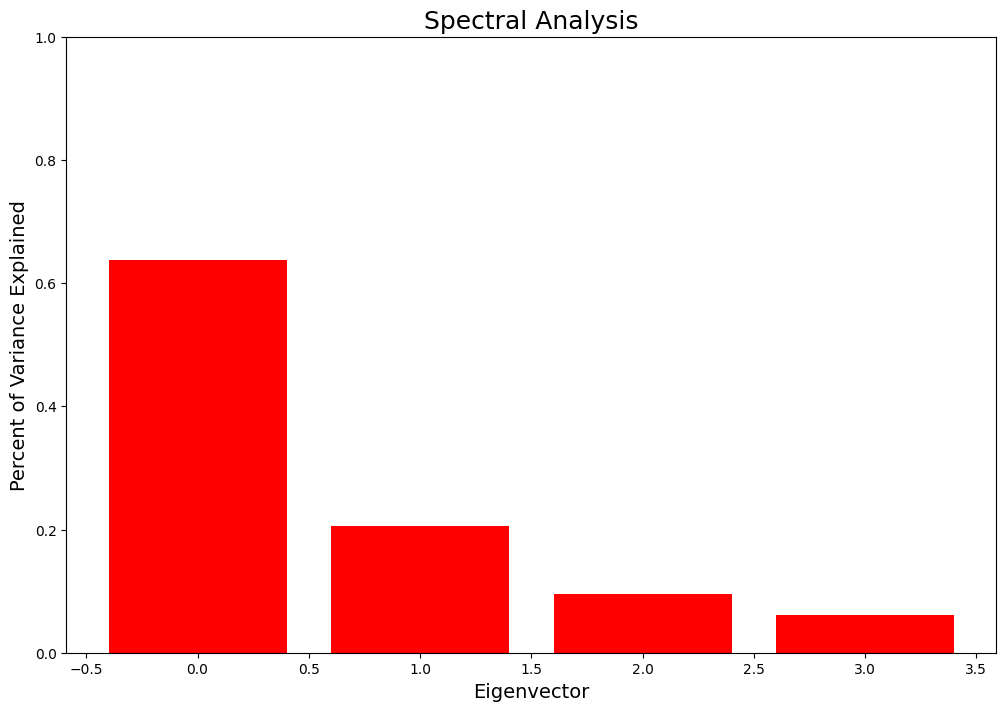

In [48]:
# Krein's Theorem
plt.figure(figsize=(12, 8))
plt.bar(np.arange(0, 4), eig_vals/sum(eig_vals), color='red')
plt.ylim([0, 1])
plt.xlabel('Eigenvector', fontsize=14)
plt.ylabel('Percent of Variance Explained', fontsize=14)
plt.title('Spectral Analysis', fontsize=18)

Portfolio: 10 Years 2nd Eigenportfolio
Sharpe Ratio: 0.206
Sortino Ratio: 0.257


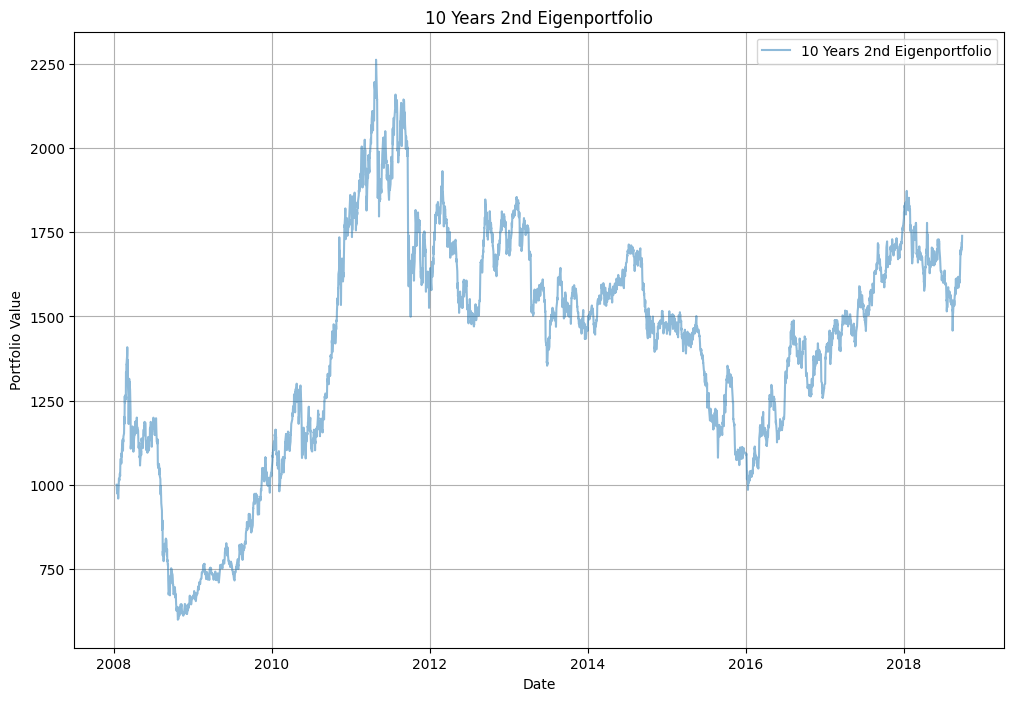

In [49]:
# Orthogonal Eigenvectors
starting_cash = 1000
second_eig_alloc = eig_vecs[1]
second_eig_alloc = second_eig_alloc/sum(np.absolute(second_eig_alloc)) * 1000

_, _, _, _ = backtest(second_eig_alloc, starting_cash, df_pct, years=10, portfolio_name='10 Years 2nd Eigenportfolio')

# backtesting

In [50]:
# backtesting
# training on the first 8 years of historical data (2008-2016)
# and then testing it on the final 2 years (2016-2018)

df_pct.iloc[4500]

date      2016-12-12 00:00:00
gold                -0.007906
silver               -0.00531
plat                -0.010811
pal                 -0.016129
Name: 6292, dtype: object

/var/folders/5h/qjd_r64j0z7_4blzpt8yc0qr0000gn/T/ipykernel_74542/576574327.py:2: FutureWarning: Calling a ufunc on non-aligned DataFrames (or DataFrame/Series combination). Currently, the indices are ignored and the result takes the index/columns of the first DataFrame. In the future , the DataFrames/Series will be aligned before applying the ufunc.
Convert one of the arguments to a NumPy array (eg 'ufunc(df1, np.asarray(df2)') to keep the current behaviour, or align manually (eg 'df1, df2 = df1.align(df2)') before passing to the ufunc to obtain the future behaviour and silence this warning.
  covariance_bt = np.matmul(vectorized_bt.T, vectorized_bt)


Portfolio: 8 Years Principal Eigenportfolio
Sharpe Ratio: -0.007
Sortino Ratio: -0.008
Portfolio: 8 Years Equal Weight Portfolio
Sharpe Ratio: 0.000
Sortino Ratio: 0.000


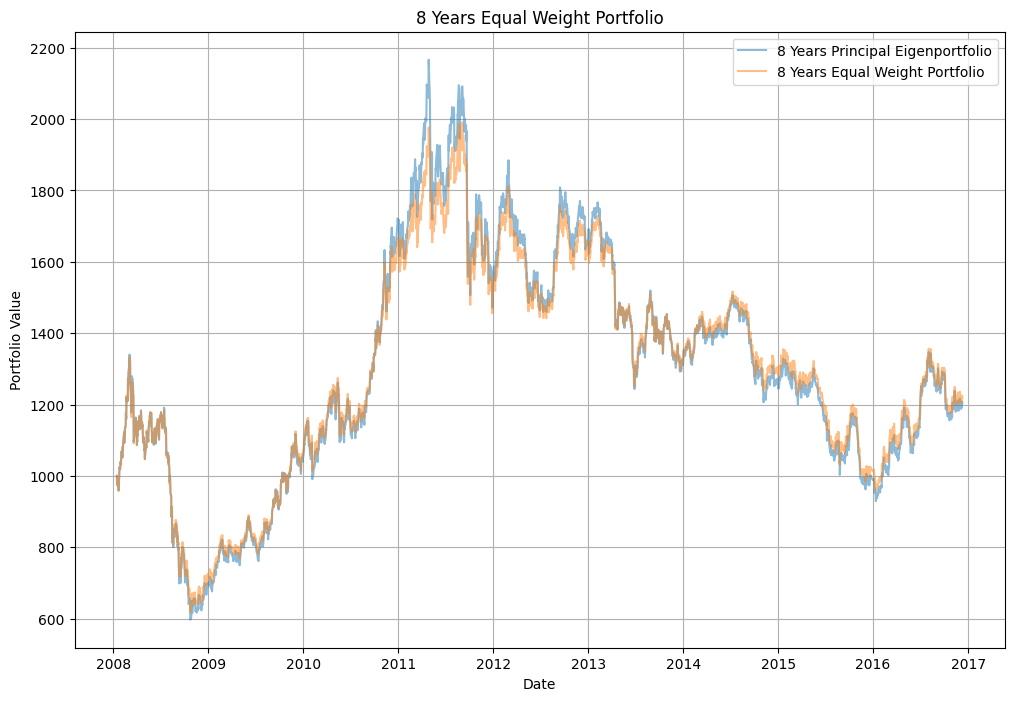

In [51]:
vectorized_bt = df_pct.iloc[:4500, 1:]
covariance_bt = np.matmul(vectorized_bt.T, vectorized_bt)

eig_vals, eig_vecs = np.linalg.eig(covariance_bt)
eig_vecs = eig_vecs.T
sort_indices = eig_vals.argsort()[::-1]
eig_vals = eig_vals[sort_indices]
eig_vecs = eig_vecs[sort_indices]

# Investing in the first principal eigenportfolio approximates the market as a whole.
first_pc = eig_vecs[0]
first_pc = first_pc / np.sum(np.absolute(first_pc))

# Backtesting and comparing the weighted Eigenportfolio and an equal weight portfolio.

starting_cash = 1000
principal_alloc = starting_cash * first_pc
equal_alloc = starting_cash * np.array([0.25, 0.25, 0.25, 0.25])

ax = plt.figure(figsize=(12, 8)).gca()

_, _, _, _ = backtest(principal_alloc, starting_cash, df_pct.iloc[:4500], years=10, portfolio_name='8 Years Principal Eigenportfolio', ax=ax)
_, _, _, _ = backtest(equal_alloc, starting_cash, df_pct[:4500], years=10, portfolio_name='8 Years Equal Weight Portfolio', ax=ax)

ax.grid()


Text(0.5, 1.0, 'Spectral Analysis')

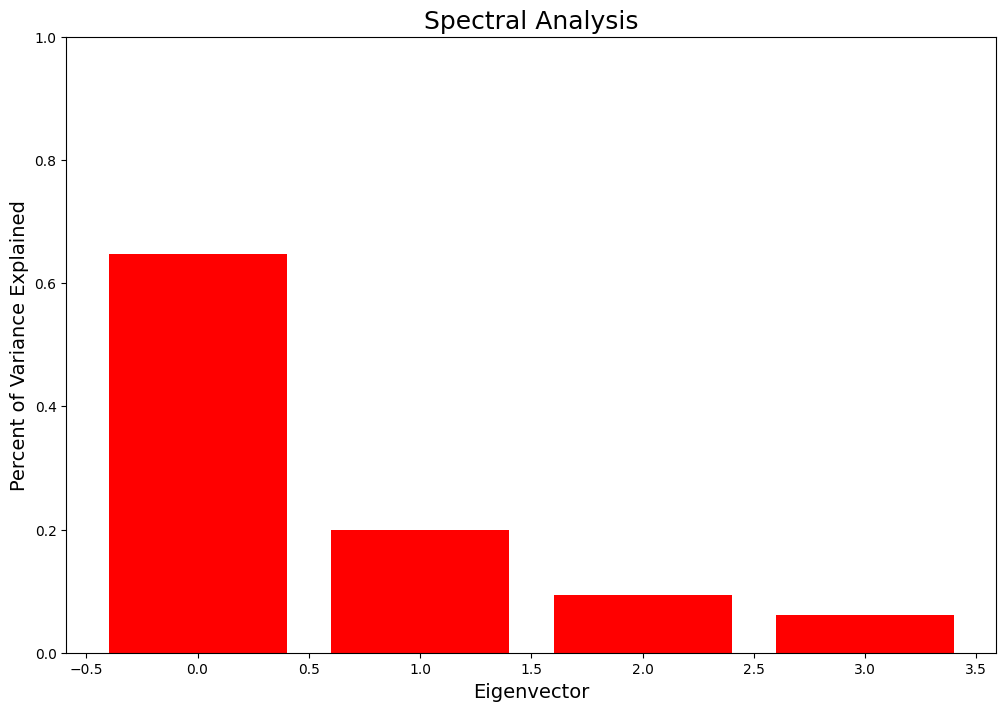

In [52]:
plt.figure(figsize=(12, 8))
plt.bar(np.arange(0, 4), eig_vals/sum(eig_vals), color='red')
plt.ylim([0, 1])
plt.xlabel('Eigenvector', fontsize=14)
plt.ylabel('Percent of Variance Explained', fontsize=14)
plt.title('Spectral Analysis', fontsize=18)

In [53]:
df_pct.iloc[4500:].reset_index()


,index,date,gold,silver,plat,pal
0,6292,2016-12-12 00:00:00,-0.007906,-0.005310,-0.010811,-0.016129
1,6293,2016-12-12 08:00:00,0.001473,0.000000,0.008743,0.003415
2,6294,2016-12-13 00:00:00,0.001081,0.008897,0.005417,-0.010211
3,6295,2016-12-13 08:00:00,0.001037,0.000000,0.006466,0.008253
4,6296,2016-12-14 00:00:00,0.002072,0.005879,0.003212,-0.004093
...,...,...,...,...,...,...
903,7217,2018-09-26 08:00:00,-0.003795,0.000000,-0.002421,0.005666
904,7218,2018-09-27 00:00:00,0.001465,-0.003800,0.006068,0.009390
905,7219,2018-09-27 08:00:00,-0.008863,0.000000,-0.020507,-0.007442
906,7220,2018-09-28 00:00:00,-0.001603,-0.007975,-0.001232,0.017807


Portfolio: Eigenportfolio
Sharpe Ratio: 0.405
Sortino Ratio: 0.577
Portfolio: Equal Allocation
Sharpe Ratio: 0.076
Sortino Ratio: 0.117


Text(0.5, 1.0, 'Eigenportfolio vs. Equal Allocation Portfolio')

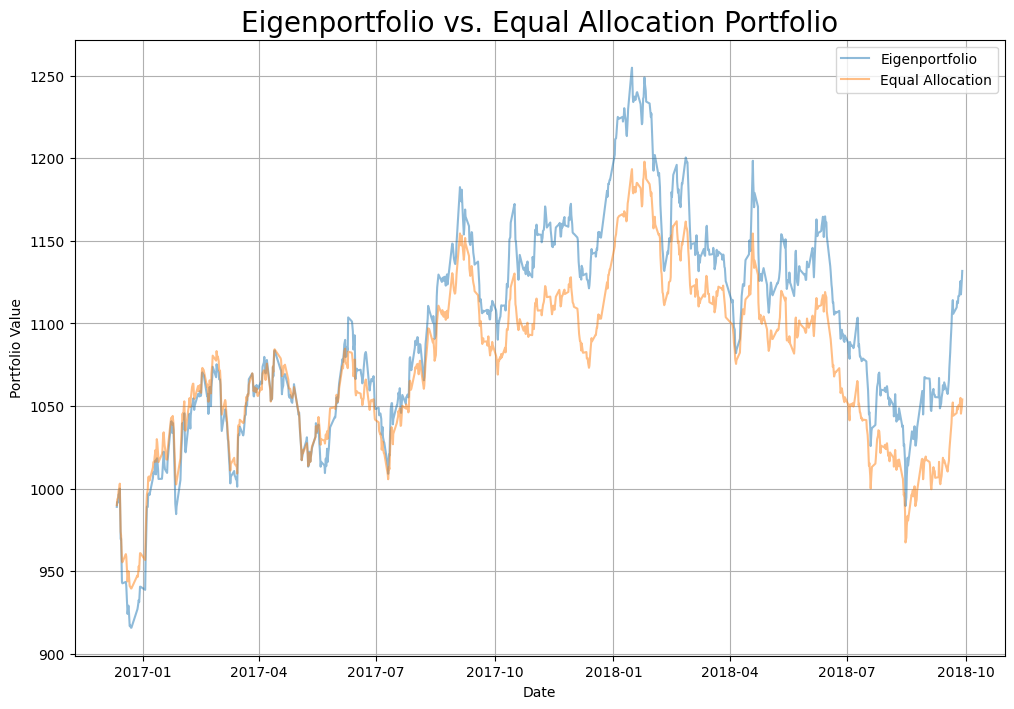

In [54]:
starting_cash = 1000
second_eig_alloc = eig_vecs[1]
second_eig_alloc = second_eig_alloc/sum(np.absolute(second_eig_alloc)) * 1000

ax = plt.figure(figsize=(12, 8)).gca()

_, _, _, _ = backtest(second_eig_alloc, starting_cash, df_pct.iloc[4500:].reset_index(drop=True), years=2, portfolio_name='Eigenportfolio', ax=ax)
_, _, _, _ = backtest(equal_alloc, starting_cash, df_pct.iloc[4500:].reset_index(drop=True), years=2, portfolio_name='Equal Allocation', ax=ax)

ax.grid()
ax.set_title('Eigenportfolio vs. Equal Allocation Portfolio', fontsize=20)

In [ ]:
print(eig_vecs[1])